In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Survey Interpretation

Imputes measured depth (MD) and angle from csv data and populates approximate wellbore geometry.

Assumes efficient vertical section (no "corkscrew" in well trajectory).

In [39]:
svy = pd.read_csv('fake_survey.csv')

svy['incrDepth'] = svy['MD'] - svy['MD'].shift().fillna(0)
svy['av_angle'] = (svy['Angle'] + svy['Angle'].shift().fillna(0))/2
svy['cos_theta'] = np.cos(svy['av_angle'] * np.pi / 180)
svy['sin_theta'] = np.sin(svy['av_angle'] * np.pi / 180)
svy['incr_tvd'] = svy['cos_theta'] * svy['incrDepth']
svy['incr_vs'] = svy['sin_theta'] * svy['incrDepth']
svy['TVD'] = svy['incr_tvd'].cumsum()
svy['VS'] = svy['incr_vs'].cumsum()

svy

,MD,Angle,incrDepth,av_angle,cos_theta,sin_theta,incr_tvd,incr_vs,TVD,VS
0,0,0,0.0,0.0,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
1,5000,0,5000.0,0.0,1.000000e+00,0.000000,5.000000e+03,0.000000,5000.000000,0.000000
2,5100,12,100.0,6.0,9.945219e-01,0.104528,9.945219e+01,10.452846,5099.452190,10.452846
3,5200,24,100.0,18.0,9.510565e-01,0.309017,9.510565e+01,30.901699,5194.557841,41.354546
4,5300,36,100.0,30.0,8.660254e-01,0.500000,8.660254e+01,50.000000,5281.160382,91.354546
5,5400,48,100.0,42.0,7.431448e-01,0.669131,7.431448e+01,66.913061,5355.474864,158.267606
6,5500,60,100.0,54.0,5.877853e-01,0.809017,5.877853e+01,80.901699,5414.253389,239.169306
7,5600,72,100.0,66.0,4.067366e-01,0.913545,4.067366e+01,91.354546,5454.927054,330.523852
8,5700,84,100.0,78.0,2.079117e-01,0.978148,2.079117e+01,97.814760,5475.718223,428.338612
9,5800,90,100.0,87.0,5.233596e-02,0.998630,5.233596e+00,99.862953,5480.951818,528.201565


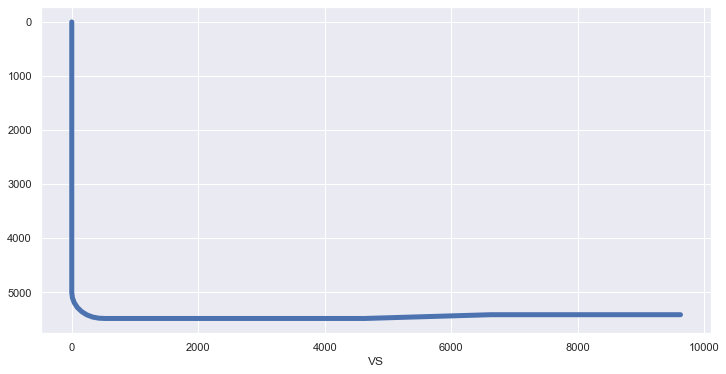

In [40]:
svy.plot(x='VS', y='TVD', figsize=(12,6), lw=5, legend=False).invert_yaxis();

# Wellbore Modeling

In [41]:
wb = pd.read_csv('fake_wellbore.csv')
wb

,wb_section,md_top,md_bottom,ID,OD,Roughness
0,tubing,0,5800,0,2.441,0.000006
1,casing,5800,11092,0,2.441,0.000006
2,restriction,11092,11103,0,2.200,0.000006
3,casing,11103,14857,0,4.778,0.000006


#### Break the wellbore into 10-ft segments:

In [42]:
max_md = wb.md_bottom.max()

bins = (np.ceil(max_md / 10) + int(max_md % 10 != 0)).astype(int)
bins

1487

In [43]:
df = pd.DataFrame(index=range(bins))
df['md_top'] = df.index * 10
df.loc[df['md_top'] > max_md, 'md_top'] = max_md
df

,md_top
0,0
1,10
2,20
3,30
4,40
...,...
1482,14820
1483,14830
1484,14840
1485,14850


In [44]:
wbdf = df.merge(wb, on='md_top', how='outer')
wbdf = wbdf.sort_values('md_top').reset_index(drop=True)
wbdf = wbdf.ffill()
wbdf

,md_top,wb_section,md_bottom,ID,OD,Roughness
0,0,tubing,5800.0,0.0,2.441,0.000006
1,10,tubing,5800.0,0.0,2.441,0.000006
2,20,tubing,5800.0,0.0,2.441,0.000006
3,30,tubing,5800.0,0.0,2.441,0.000006
4,40,tubing,5800.0,0.0,2.441,0.000006
...,...,...,...,...,...,...
1484,14820,casing,14857.0,0.0,4.778,0.000006
1485,14830,casing,14857.0,0.0,4.778,0.000006
1486,14840,casing,14857.0,0.0,4.778,0.000006
1487,14850,casing,14857.0,0.0,4.778,0.000006


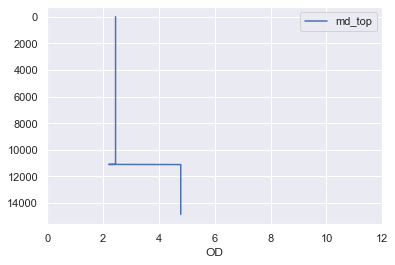

In [45]:
wbdf.plot(x='OD', y='md_top', xlim=(0,12)).invert_yaxis()

In [46]:
# wbdf.to_excel('test_wb.xlsx')

link for working on pressure loss:
https://www.ihsenergy.ca/support/documentation_ca/Harmony/content/html_files/reference_material/calculations_and_correlations/pressure_loss_calculations.htm